<a href="https://colab.research.google.com/github/AjayKumarGogineni777/covid_cnn/blob/main/Covid_classification_EffNet_SeRexnext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# path_img = '/content/gdrive/My Drive/Sage Health/X ray/classification/'
path_img = '/content/gdrive/My Drive/Sage Health/X ray/new_images/'
import os
os.listdir(path_img)

['train', 'test', 'valid', 'models_old', 'models']

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
il = ImageList.from_folder(path_img, convert_mode='L')
il[:5]

ImageList (5 items)
Image (1, 891, 880),Image (1, 876, 882),Image (1, 888, 882),Image (1, 874, 880),Image (1, 1148, 2563)
Path: /content/gdrive/My Drive/Sage Health/X ray/new_images

In [ ]:
# il.items[0]

In [ ]:
bs = 2
defaults.cmap='binary'
fnames = get_image_files(path_img)

In [ ]:
## size = 420 for densenet
## size = 720 for resnet

In [ ]:
data = ImageDataBunch.from_folder(path_img,size = 420,ds_tfms=get_transforms(), test = 'test', num_workers=4, bs = 16).normalize(imagenet_stats)

In [ ]:
data.train_ds

LabelList (1717 items)
x: ImageList
Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420)
y: CategoryList
covid,covid,covid,covid,covid
Path: /content/gdrive/My Drive/Sage Health/X ray/new_images

In [ ]:
data.valid_ds

LabelList (371 items)
x: ImageList
Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420)
y: CategoryList
normal,normal,normal,normal,normal
Path: /content/gdrive/My Drive/Sage Health/X ray/new_images

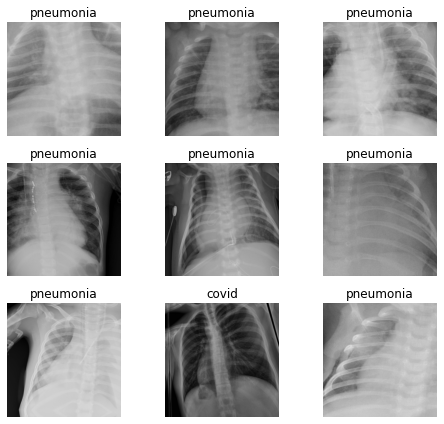

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
print(data.classes)
len(data.classes),data.c

['covid', 'normal', 'pneumonia']


(3, 3)

In [ ]:
data.test_ds

LabelList (372 items)
x: ImageList
Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420)
y: EmptyLabelList
,,,,
Path: /content/gdrive/My Drive/Sage Health/X ray/new_images

In [ ]:
path_models = path_img + 'models/'

In [ ]:
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduction='elementwise_mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)

In [ ]:
#!pip install cnn_finetune

     |████████████████████████████████| 61kB 2.8MB/s 
  Created wheel for cnn-finetune: filename=cnn_finetune-0.6.0-cp36-none-any.whl size=11430 sha256=2d325e39dcd94a575eaaea94c32c28783285582e4fb4e30988589f997dbbbb17
  Stored in directory: /root/.cache/pip/wheels/12/4f/29/32978e72b606c5f51b6bd10117814deb46c6b63230eef49381
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60964 sha256=6c39869e6c2e6b4c87ab99db52e2e708efd946da6494feb19409c2d3d6d32f28
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built cnn-finetune pretrainedmodels


In [ ]:
## SeResNext
from cnn_finetune import make_model

model = make_model('se_resnext50_32x4d', num_classes=3, pretrained=True, input_size=(420, 420))

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


In [ ]:
import torchvision.models as models
#resnet18 = models.resnet18(pretrained=True)
#alexnet = models.alexnet(pretrained=True)
#squeezenet = models.squeezenet1_0(pretrained=True)
#vgg16 = models.vgg16(pretrained=True)
# densenet = models.densenet161(pretrained=True)
#inception = models.inception_v3(pretrained=True)
#googlenet = models.googlenet(pretrained=True)
#shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
#mobilenet = models.mobilenet_v2(pretrained=True)
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


In [ ]:
# learn = cnn_learner(data, models.resnet34, metrics=error_rate)

learn = cnn_learner(data, models.resnext50_32x4d, metrics = accuracy)

#learn = cnn_learner(data, model, metrics = accuracy)

learn.loss_fn = FocalLoss()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


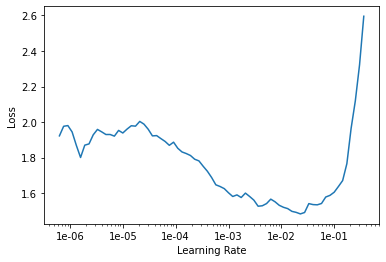

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr = 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.724895,1.490566,0.714286,03:09
1,0.528632,0.344762,0.873315,02:42
2,0.316668,0.296422,0.886792,02:43
3,0.242238,0.264198,0.892183,02:43


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f511f5be208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f511f5be208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    sel

In [ ]:
learn.save(path_models + 'epoch-4-1e-3-resnext-focal')

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-4, 3e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.179067,0.296724,0.884097,02:41
1,0.222946,0.399125,0.889488,02:40
2,0.243483,0.692539,0.781671,02:41
3,0.265966,0.426463,0.865229,02:42
4,0.218348,0.343941,0.892183,02:42
5,0.179597,0.306196,0.913747,02:38
6,0.149659,0.345930,0.859838,02:40
7,0.146935,0.266971,0.911051,02:38
8,0.128122,0.302834,0.889488,02:38
9,0.129936,0.274040,0.908356,02:39


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f511f5be208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f511f5be208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    sel

In [ ]:
learn.save(path_models + 'epoch-14-1e-3-resnext-focal')

In [ ]:
learn.load(path_models + 'epoch-14-1e-3-resnext-focal');

In [ ]:
learn.fit_one_cycle(6, max_lr=slice(1e-4, 8e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.145898,0.285853,0.897574,02:38
1,0.153858,0.336026,0.884097,02:38
2,0.131468,0.297841,0.902965,02:38
3,0.129512,0.266620,0.905660,02:39
4,0.117339,0.316931,0.884097,02:39
5,0.108945,0.286882,0.900270,02:38


In [ ]:
learn.save(path_models + 'epoch-20-8e-4-resnext-focal')

In [ ]:
learn.fit_one_cycle(6, max_lr=slice(1e-4, 5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.098789,0.294014,0.908356,02:39
1,0.100340,0.290447,0.902965,02:39
2,0.117495,0.292024,0.911051,02:38
3,0.081096,0.288986,0.913747,02:39
4,0.087067,0.328999,0.894879,02:39
5,0.076868,0.296102,0.916442,02:40


In [ ]:
learn.save(path_models + 'epoch-26-2e-2-resnext-focal')

In [ ]:
#learn.load(path_models + 'epoch-20-2e-3-resnet34');

In [ ]:
predictions, y1 = learn.get_preds(DatasetType.Test)
preds = np.argmax(predictions, axis = 1)
preds, len(preds)

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2,
         2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2

In [ ]:
t1 = [0 for i in range(72)]
t2 = [1 for i in range(150)]
t3 = [2 for i in range(150)]
arr = t1+t2+t3
arr = np.asarray(arr)
len(arr)

372

In [ ]:
import torch
target = torch.from_numpy(arr)
target

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
## 26 epochs
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(target, preds)
print(classification_report(target, preds))
cm

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        72
           1       0.99      0.97      0.98       150
           2       0.93      0.90      0.92       150

    accuracy                           0.92       372
   macro avg       0.90      0.91      0.91       372
weighted avg       0.93      0.92      0.92       372



array([[ 62,   2,   8],
       [  2, 146,   2],
       [ 15,   0, 135]])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(target, preds)
print(classification_report(target, preds))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        72
           1       0.99      0.97      0.98       150
           2       0.93      0.90      0.92       150

    accuracy                           0.92       372
   macro avg       0.90      0.91      0.91       372
weighted avg       0.93      0.92      0.92       372



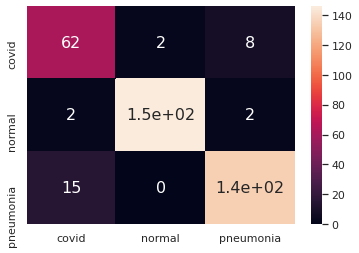

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = cm
df_cm = pd.DataFrame(array, index=["covid", "normal", "pneumonia"],
                     columns=["covid", "normal", "pneumonia"])
#df_cm = pd.DataFrame(array, range(3), range(3))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.0) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

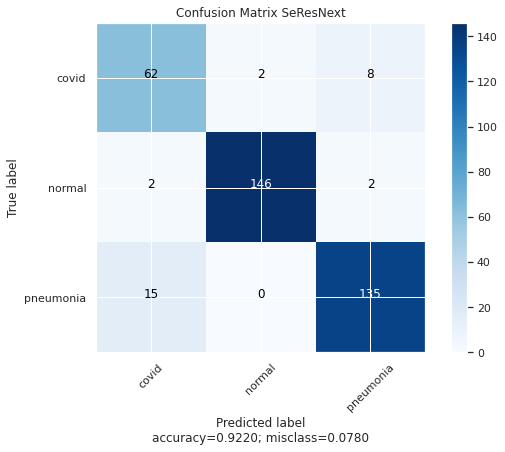

In [ ]:
import numpy as np
cm = np.array([[ 62,   2,   8],
       [  2, 146,   2],
       [ 15,   0, 135]])
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()




plot_confusion_matrix(cm = np.array([[ 62,   2,   8],
                                      [  2, 146,   2],
                                      [ 15,   0, 135]]), 
                      normalize    = False,
                      target_names = ["covid", "normal", "pneumonia"],
                      title        = "Confusion Matrix SeResNext")

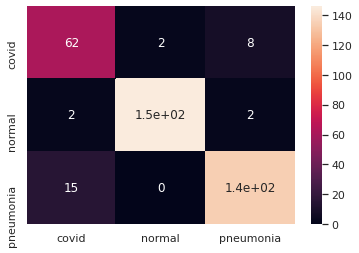

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = cm
df_cm = pd.DataFrame(array, index=["covid", "normal", "pneumonia"],
                     columns=["covid", "normal", "pneumonia"])
#df_cm = pd.DataFrame(array, range(3), range(3))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.0) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size

plt.show()

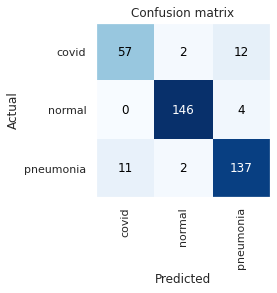

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

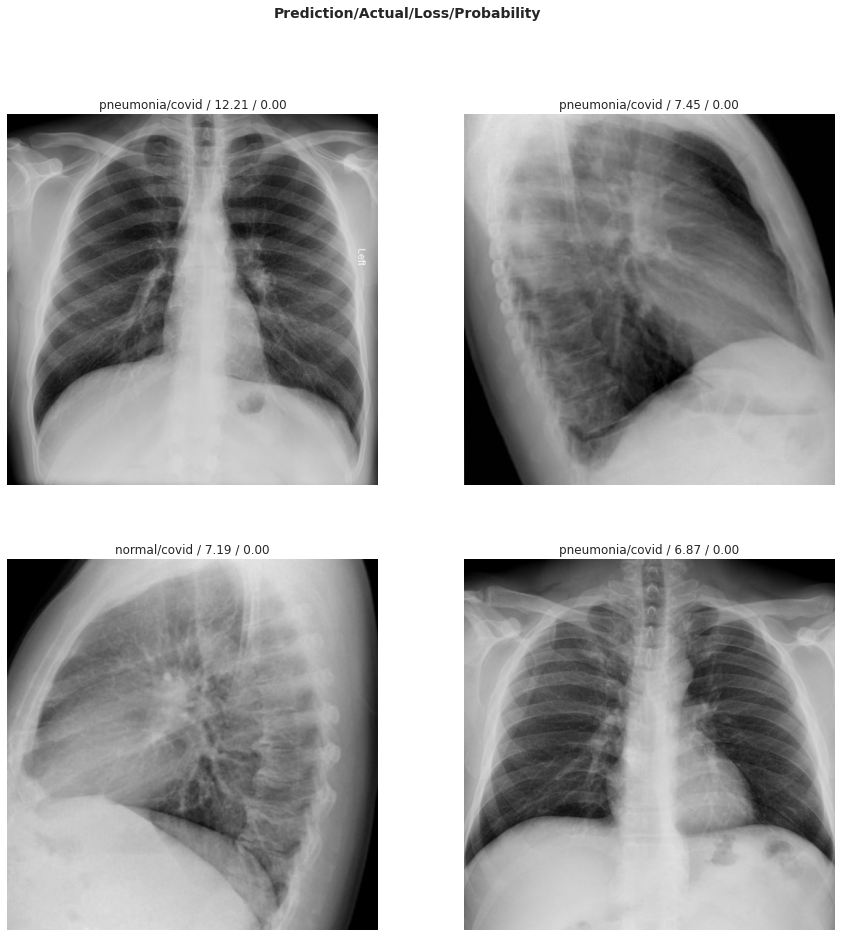

In [ ]:
interp.plot_top_losses(4, figsize=(15,15))


In [ ]:
log_preds,y = learn.TTA()
# probs = np.mean(np.exp(log_preds),0)

In [ ]:
tta_preds = np.argmax(np.exp(log_preds), axis = 1)

In [ ]:
log_preds.shape

In [ ]:
y

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y, tta_preds)
print(classification_report(y, tta_preds))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87        71
           1       0.99      1.00      1.00       150
           2       0.94      0.94      0.94       150

    accuracy                           0.95       371
   macro avg       0.93      0.93      0.93       371
weighted avg       0.95      0.95      0.95       371



In [ ]:
cm

array([[ 61,   1,   9],
       [  0, 150,   0],
       [  9,   0, 141]])

In [ ]:
# preds = np.argmax(predictions, axis = 1)
# preds, len(preds)

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

In [ ]:
## EfficientNet
n_channels_dict = {'efficientnet-b0': 1280, 'efficientnet-b1': 1280, 'efficientnet-b2': 1408,
                           'efficientnet-b3': 1536, 'efficientnet-b4': 1792, 'efficientnet-b5': 2048,
                           'efficientnet-b6': 2304, 'efficientnet-b7': 2560}
model_name = 'efficientnet-b0'
num = n_channels_dict[model_name]
model = EfficientNet.from_name(model_name)
model._fc = nn.Linear(num, data.c)
learn = Learner(data, model, metrics=error_rate)

In [ ]:
#learn = cnn_learner(data, models.densenet121, metrics=error_rate)

learn.loss_fn = FocalLoss()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


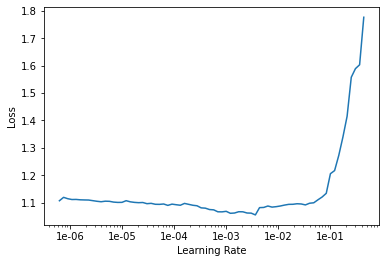

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
path_models = path_img + 'models/'

In [ ]:
learn.fit_one_cycle(4, max_lr = 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.960474,1.082322,0.595687,02:02
1,0.859670,1.218090,0.595687,02:00
2,0.765465,1.147571,0.595687,02:01
3,0.687730,0.986023,0.469003,02:00


In [ ]:
learn.save(path_models + 'epoch-4-1e-3-efficientnet-b0-focal')


In [ ]:
#learn.load(path_models + 'epoch-4-1e-3-efficientnet-b0-focal');

In [ ]:
learn.fit_one_cycle(10, max_lr = 8e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.653984,0.748614,0.269542,02:02
1,0.697018,1.512458,0.487871,02:00
2,0.691367,1.130445,0.393531,02:00
3,0.690593,1.175645,0.326146,01:58
4,0.653398,0.539146,0.204852,01:58
5,0.587881,2.419321,0.533693,02:00
6,0.581152,0.615173,0.258760,02:00
7,0.540060,0.734308,0.269542,01:58
8,0.514678,0.453044,0.172507,01:58
9,0.467383,0.379946,0.142857,01:58


In [ ]:
learn.save(path_models + 'epoch-14-8e-4-efficientnet-b0-focal')

In [ ]:
learn.load(path_models + 'epoch-14-8e-4-efficientnet-b0-focal');

In [ ]:
learn.fit_one_cycle(6, max_lr = 5e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.447057,0.410920,0.150943,01:56
1,0.523879,0.828318,0.283019,01:56
2,0.511082,0.320391,0.115903,01:57
3,0.501520,0.317801,0.105121,01:59
4,0.444606,0.292110,0.105121,02:00
5,0.426769,0.283396,0.107817,02:01


In [ ]:
learn.save(path_models + 'epoch-20-5e-4-efficientnet-b0-focal')

In [ ]:
learn.fit_one_cycle(6, max_lr=slice(7e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.408225,0.378366,0.140162,02:02
1,0.501374,1.175268,0.412399,02:01
2,0.505428,0.611396,0.210243,02:02
3,0.441000,0.405354,0.150943,02:03
4,0.381033,0.267303,0.110512,02:03
5,0.379990,0.264849,0.107817,02:04


In [ ]:
learn.save(path_models + 'epoch-26-7e-4-efficientnet-b0-focal')

In [ ]:
#learn.load(path_models + 'epoch-20-2e-3-resnet34');

In [ ]:
predictions, y1 = learn.get_preds(DatasetType.Test)
preds = np.argmax(predictions, axis = 1)
preds, len(preds)

(tensor([1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
         1, 2, 2, 0, 0, 0, 1, 0, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2

In [ ]:
t1 = [0 for i in range(72)]
t2 = [1 for i in range(150)]
t3 = [2 for i in range(150)]
arr = t1+t2+t3
arr = np.asarray(arr)
len(arr)

372

In [ ]:
import torch
target = torch.from_numpy(arr)
target

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
## 26 epochs densenet121
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(target, preds)
print(classification_report(target, preds))
cm

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        72
           1       0.88      1.00      0.93       150
           2       0.96      0.83      0.89       150

    accuracy                           0.90       372
   macro avg       0.89      0.88      0.88       372
weighted avg       0.90      0.90      0.89       372



array([[ 59,   8,   5],
       [  0, 150,   0],
       [ 13,  13, 124]])

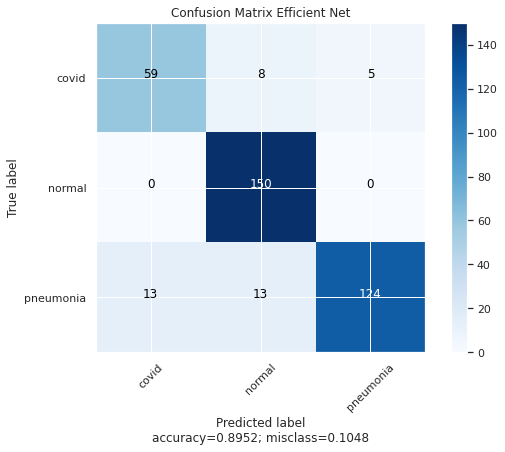

In [ ]:
import numpy as np
cm = np.array([[ 59,   8,   5],
       [  0, 150,   0],
       [ 13,  13, 124]])
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()




plot_confusion_matrix(cm = np.array([[ 59,   8,   5],
                                      [  0, 150,   0],
                                      [ 13,  13, 124]]), 
                      normalize    = False,
                      target_names = ["covid", "normal", "pneumonia"],
                      title        = "Confusion Matrix Efficient Net")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(target, preds)
print(classification_report(target, preds))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        72
           1       0.88      1.00      0.93       150
           2       0.96      0.83      0.89       150

    accuracy                           0.90       372
   macro avg       0.89      0.88      0.88       372
weighted avg       0.90      0.90      0.89       372



In [ ]:
cm## 20 epochs densenet121

array([[ 59,   8,   5],
       [  0, 150,   0],
       [ 13,  13, 124]])

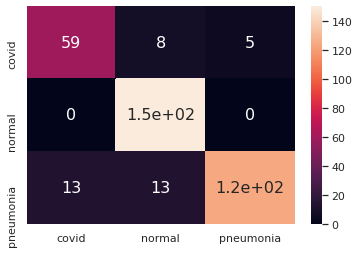

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = cm
df_cm = pd.DataFrame(array, index=["covid", "normal", "pneumonia"],
                     columns=["covid", "normal", "pneumonia"])
#df_cm = pd.DataFrame(array, range(3), range(3))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.0) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

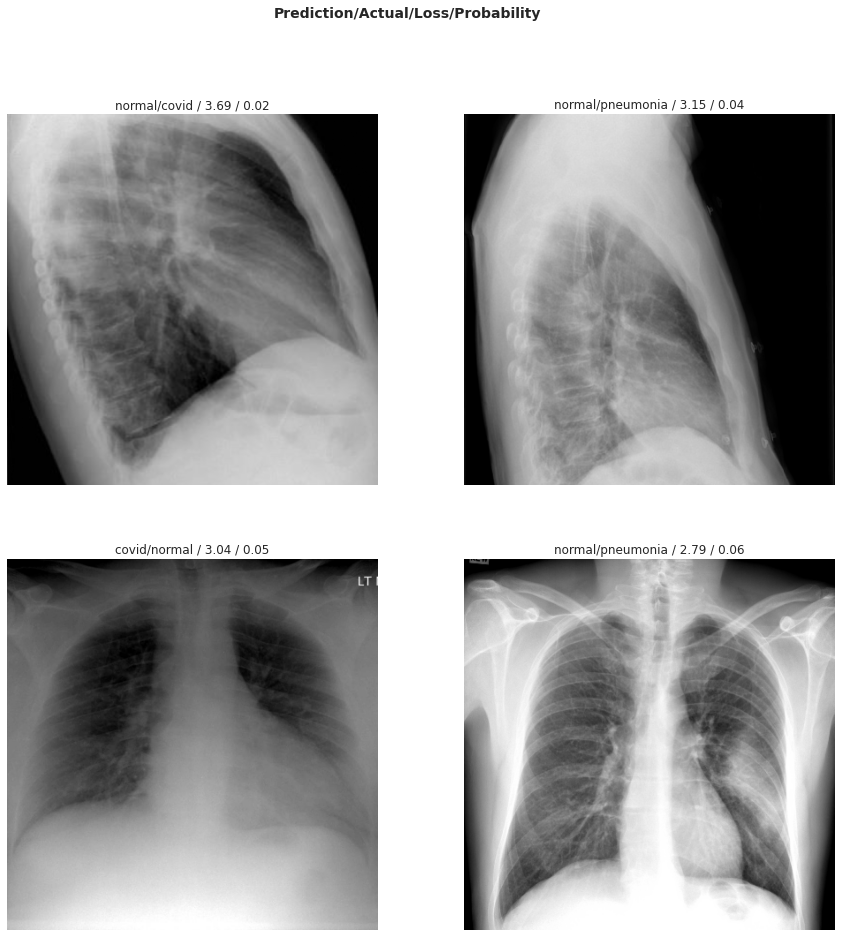

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix()

interp.plot_top_losses(4, figsize=(15,15))
